## 2,000 Cleaned Medical Articles: Causal Language Modeling

Dataset Source: https://www.kaggle.com/datasets/trikialaaa/2k-clean-medical-articles-medicalnewstoday

#### Import Necessary & Missing Libraries

In [1]:
import os, sys, glob, math

import pandas as pd

import matplotlib.pyplot as plt

import datasets
from datasets import ClassLabel, Dataset, DatasetDict

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer, set_seed

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.9.12
        Pandas: 1.5.0
      Datasets: 2.9.0
  Transformers: 4.26.1


#### Load Dataset

In [3]:
parent_dir = "/Users/briandunn/Desktop/nlp_ds/Causal Language Modeling/2k Clean Medical Articles/articles"

data_values = [pd.read_csv(filename, sep="\t", engine="c", header=None, names=["text"]) for filename in glob.glob(os.path.join(parent_dir, "*txt"))]

data = pd.concat(data_values)

data = data.drop_duplicates()
data = data.dropna()

data = data.apply(lambda x: x.str.strip())

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1979 entries, 0 to 0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1979 non-null   object
dtypes: object(1)
memory usage: 30.9+ KB


#### Visual: Histogram of Input Lengths

The maximum length of this dataset is approximately 17093 words.


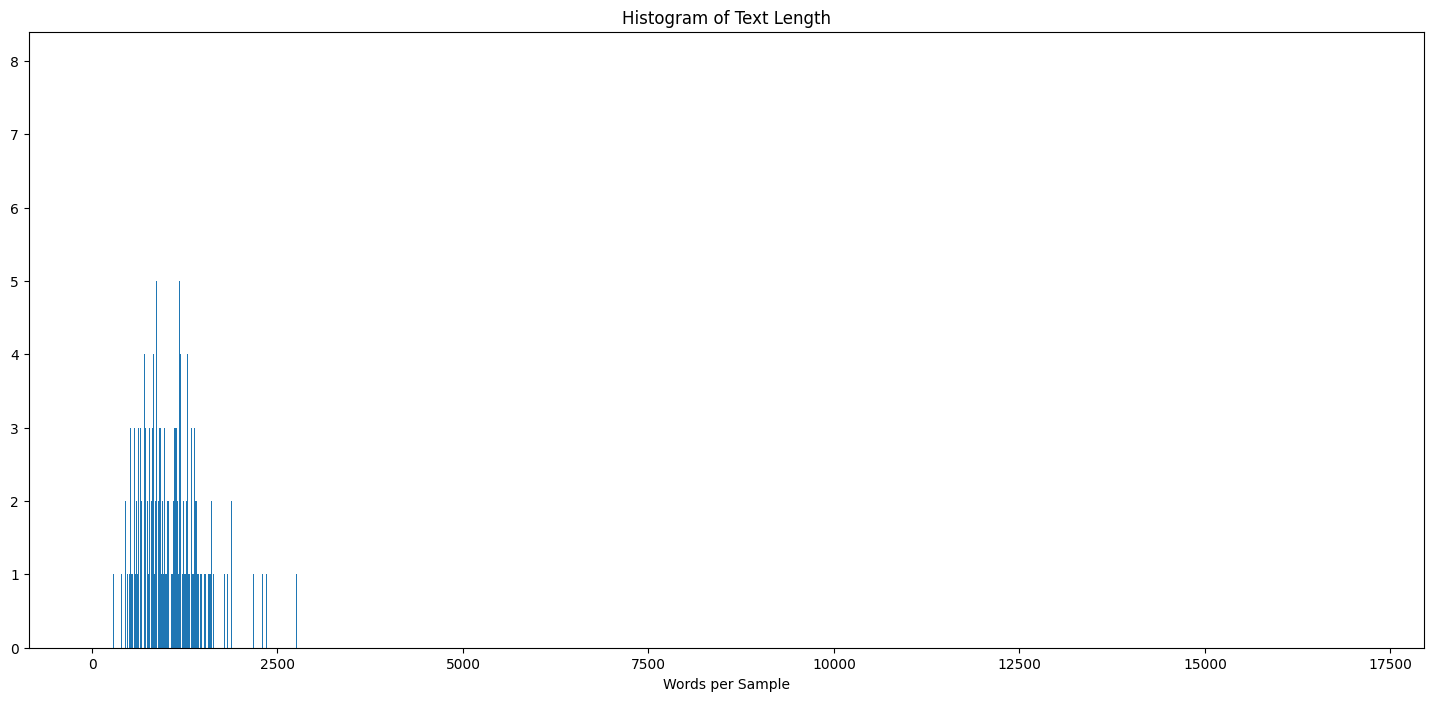

In [4]:
data['input_len'] = data['text'].str.split().str.len()

max_len = max(data['input_len'])
print(f"The maximum length of this dataset is approximately {max_len} words.")

n = max_len
data.hist('input_len', grid=False, figsize=(18,8), range=(0, n), bins=n)
plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Sample')
plt.show()

#### Remove Overly Length Input Texts & Remove Unnecessary Features

In [5]:
data = data[data["input_len"] < 2500]

data = data.drop(columns=["input_len"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1934 entries, 0 to 0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1934 non-null   object
dtypes: object(1)
memory usage: 30.2+ KB


#### Convert DataFrame to Dataset

In [6]:
dataset = Dataset.from_pandas(data)

#### Split Dataset into Training & Evaluation Datasets

In [7]:
train_eval_dataset = dataset.train_test_split(test_size=0.20)

ds = DatasetDict({
    'train' : train_eval_dataset["train"],
    'eval' : train_eval_dataset["test"]
})

print('Training data shape:', ds['train'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (1547, 2)
Eval data shape: (387, 2)


#### Basic Values/Constants

In [8]:
BLOCK_SIZE = 128
MODEL_CKPT = "distilgpt2"

MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-2k_clean_medical_articles_causal_language_model"
set_seed = 42

BATCH_SIZE = 1000 
NUM_OF_EPOCHS = 3

WEIGHT_DECAY = 0.01
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
LEARNING_RATE = 2e-5

#### Tokenize Entire Dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, use_fast=True)

def tokenizer_function(samples):
    return tokenizer(samples["text"])

#### Apply Tokenizer Function to Entire Dataset

In [10]:
tokenized_ds = ds.map(tokenizer_function, 
                      batched=True,
                      remove_columns=ds["train"].column_names,)

tokenized_ds["train"]

A Jupyter Widget

Token indices sequence length is longer than the specified maximum sequence length for this model (1211 > 1024). Running this sequence through the model will result in indexing errors


A Jupyter Widget

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1547
})

#### Preprocess Tokenized Dataset

In [11]:
def group_texts(samples):
    concatenated_examples = {k: sum(samples[k], []) for k in samples.keys()}
    total_length = len(concatenated_examples[list(samples.keys())[0]])
    total_length = (total_length // BLOCK_SIZE) * BLOCK_SIZE
    result = {
        k: [t[i : i + BLOCK_SIZE] for i in range(0, total_length, BLOCK_SIZE)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

#### Apply Preprocessing Function to Dataset

In [12]:
clm_ds = tokenized_ds.map(
    group_texts,
    batched=True,
    num_proc=2,
)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

#### Instantiate Model

In [13]:
model = AutoModelForCausalLM.from_pretrained(MODEL_CKPT)

#### Define Data Collator

In [14]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

#### Define TrainingArguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=NUM_OF_EPOCHS,
    report_to=REPORTS_TO,
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Trainer

In [16]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=clm_ds["train"],
    eval_dataset=clm_ds["eval"],
    data_collator=data_collator,
)

Cloning https://huggingface.co/DunnBC22/distilgpt2-2k_clean_medical_articles_causal_language_model into local empty directory.


#### Train Model

In [17]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 15921
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5973
  Number of trainable parameters = 81912576


A Jupyter Widget

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-500
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-500/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-500/generation_config.json


{'loss': 3.2551, 'learning_rate': 1.832579943077181e-05, 'epoch': 0.25}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-1000
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-1000/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-1000/generation_config.json


{'loss': 3.1543, 'learning_rate': 1.6651598861543614e-05, 'epoch': 0.5}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-1500
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-1500/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-1500/generation_config.json


{'loss': 3.1211, 'learning_rate': 1.4977398292315422e-05, 'epoch': 0.75}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4029
  Batch size = 8


A Jupyter Widget

{'eval_loss': 2.9739990234375, 'eval_runtime': 2324.7462, 'eval_samples_per_second': 1.733, 'eval_steps_per_second': 0.217, 'epoch': 1.0}


Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-2000
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-2000/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-2000/generation_config.json


{'loss': 3.0909, 'learning_rate': 1.3303197723087226e-05, 'epoch': 1.0}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-2500
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-2500/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-2500/generation_config.json


{'loss': 3.0184, 'learning_rate': 1.1628997153859034e-05, 'epoch': 1.26}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-3000
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-3000/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-3000/generation_config.json


{'loss': 3.0144, 'learning_rate': 9.95479658463084e-06, 'epoch': 1.51}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-3000/pytorch_model.bin
Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-3500
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-3500/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-3500/generation_config.json


{'loss': 2.998, 'learning_rate': 8.280596015402646e-06, 'epoch': 1.76}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-3500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4029
  Batch size = 8


A Jupyter Widget

{'eval_loss': 2.9366679191589355, 'eval_runtime': 2374.4091, 'eval_samples_per_second': 1.697, 'eval_steps_per_second': 0.212, 'epoch': 2.0}


Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-4000
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-4000/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-4000/generation_config.json


{'loss': 2.981, 'learning_rate': 6.606395446174452e-06, 'epoch': 2.01}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-4000/pytorch_model.bin
Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-4500
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-4500/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-4500/generation_config.json


{'loss': 2.9605, 'learning_rate': 4.932194876946258e-06, 'epoch': 2.26}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-4500/pytorch_model.bin
Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-5000
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-5000/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-5000/generation_config.json


{'loss': 2.9476, 'learning_rate': 3.2579943077180647e-06, 'epoch': 2.51}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-5000/pytorch_model.bin
Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-5500
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-5500/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-5500/generation_config.json


{'loss': 2.9484, 'learning_rate': 1.5837937384898713e-06, 'epoch': 2.76}


Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/checkpoint-5500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4029
  Batch size = 8


A Jupyter Widget



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 2.9268078804016113, 'eval_runtime': 2449.0702, 'eval_samples_per_second': 1.645, 'eval_steps_per_second': 0.206, 'epoch': 3.0}
{'train_runtime': 90899.7407, 'train_samples_per_second': 0.525, 'train_steps_per_second': 0.066, 'train_loss': 3.036437467137274, 'epoch': 3.0}


#### Evaluate Model

In [18]:
evaluation_results = trainer.evaluate()
print(f"Perplexity: {math.exp(evaluation_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 4029
  Batch size = 8


A Jupyter Widget

Perplexity: 18.67


#### Push Model to HuggingFace Hub

In [19]:
trainer.push_to_hub()

Saving model checkpoint to distilgpt2-2k_clean_medical_articles_causal_language_model
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/config.json
Configuration saved in distilgpt2-2k_clean_medical_articles_causal_language_model/generation_config.json
Model weights saved in distilgpt2-2k_clean_medical_articles_causal_language_model/pytorch_model.bin


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilgpt2-2k_clean_medical_articles_causal_language_model
   e3c7ec6..b0ccf87  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Causal Language Modeling', 'type': 'text-generation'}}
To https://huggingface.co/DunnBC22/distilgpt2-2k_clean_medical_articles_causal_language_model
   b0ccf87..10df069  main -> main



'https://huggingface.co/DunnBC22/distilgpt2-2k_clean_medical_articles_causal_language_model/commit/b0ccf876668dc3bd09a53f5ce5af39ecec767a5f'

### Notes & Other Takeaways From This Project
****
- DistilGPT2 reached a perplexity of 21.1 after fine tuning, so the perlexity score here of 18.67 is pretty good.
****

### Citations

- Model Checkpoint
    - @inproceedings{sanh2019distilbert,
  title={DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter},
  author={Sanh, Victor and Debut, Lysandre and Chaumond, Julien and Wolf, Thomas},
  booktitle={NeurIPS EMC^2 Workshop},
  year={2019}
}